In [ ]:
import numpy as np
import pandas as pd 
from numba import jit
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt

### Data Preparation

In [ ]:
def prepare_data_kibot(raw_data_path, out_data_path):
    df = pd.read_csv(raw_data_path,
                     header=None,
                     names=['day', 'time', 'price', 'bid', 'ask', 'vol'])
    df['date'] = pd.to_datetime(df['day'] + df['time'],
                                format='%m/%d/%Y%H:%M:%S')
    df['dollar_vol'] = df['price']*df['vol']
    df = df.set_index('date')
    df = df.drop(['day', 'time'],
                 axis=1)
    df = df.drop_duplicates()
    df.to_parquet(out_data_path)

In [ ]:
raw_data_path = '/content/drive/MyDrive/퀀트/data/IVE_tickbidask.txt'
out_data_path = '/content/drive/MyDrive/퀀트/data/IVE_tickbidask.parq'
prepare_data_kibot(raw_data_path, out_data_path)

### Data Cleaning

In [ ]:
out_data_path = '/content/drive/MyDrive/퀀트/data/IVE_tickbidask.parq'
df = pd.read_parquet(out_data_path)

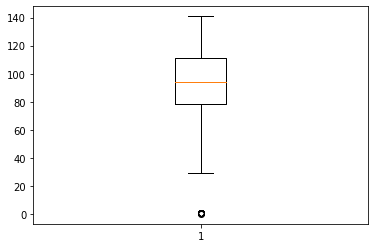

In [ ]:
fig, ax = plt.subplots()
_ = ax.boxplot(df.price)

In [ ]:
Q1 = df.price.describe()[4] 
Q3 = df.price.describe()[6]
IQR = Q3- Q1
df = df.query('price > @Q1 - 1.5*@IQR') # 이상치 처리 (11개)

clean_data_path = '/content/drive/MyDrive/퀀트/data/clean_IVE_tickbidask.parq'
df.to_parquet(clean_data_path)

### Data

In [ ]:
df

,price,bid,ask,vol,dollar_vol
date,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,15225.00
...,...,...,...,...,...
2021-03-10 15:59:59,140.47,140.42,140.47,213,29920.11
2021-03-10 16:00:00,140.50,140.45,140.50,10692,1502226.00
2021-03-10 16:10:00,140.50,140.51,141.14,0,0.00


In [ ]:
#! pip install https://github.com/matplotlib/mpl_finance/archive/master.zip

     / 450kB 3.4MB/s
  Created wheel for mpl-finance: filename=mpl_finance-0.10.1-cp37-none-any.whl size=8424 sha256=43d2cac93c6837b4e9173385ed4d52e4d6bd318a50399717c39347646bf574a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-pvmect66/wheels/8f/bf/8a/6c858b2a3be945c7b2d658fbf6ab797b451d686cbee8aa2679
Successfully built mpl-finance


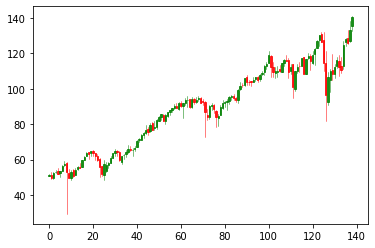

In [ ]:
from mpl_finance import candlestick_ohlc

df_ohlc = df.price.resample('1M').ohlc()
x = np.arange(len(df_ohlc.index))
dohlc = np.hstack((np.reshape(x, (-1, 1)), df_ohlc))

fig, ax = plt.subplots()

candlestick_ohlc(ax, dohlc,  width=0.6, colorup='green', colordown='red', alpha=0.8)
plt.show()

## `2.1` 
On a series of E-mini S&P 500 futures tick data:

(a) Form tick, volume, and dollar bars. Use the ETF trick to deal with the roll.

In [ ]:
def tick_bars(df, price_column, m):
    '''
    compute tick bars
    # args
        df: pd.DataFrame()
        column: name for price data
        m: int(), threshold value for ticks
    # returns
        idx: list of indices
    '''
    t = df[price_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += 1
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def tick_bar_df(df, price_column, m):
    idx = tick_bars(df, price_column, m)
    return df.iloc[idx]

In [ ]:
tick_df = tick_bar_df(df, 'price', 2)

100%|██████████| 2055555/2055555 [00:01<00:00, 2014084.39it/s]


In [ ]:
def volume_bars(df, volume_column, m):
    '''
    compute volume bars
    # args
        df: pd.DataFrame()
        column: name for volume data
        m: int(), threshold value for volume
    # returns
        idx: list of indices
    '''
    t = df[volume_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def volume_bar_df(df, volume_column, m):
    idx = volume_bars(df, volume_column, m)
    return df.iloc[idx]


In [ ]:
vol_df = volume_bar_df(df, 'vol', 600)

100%|██████████| 2055555/2055555 [00:01<00:00, 1968453.72it/s]


In [ ]:
def dollar_bars(df, dv_column, m):
    '''
    compute dollar bars
    # args
        df: pd.DataFrame()
        column: name for dollar volume data
        m: int(), threshold value for dollars
    # returns
        idx: list of indices
    '''
    t = df[dv_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def dollar_bar_df(df, dv_column, m):
    idx = dollar_bars(df, dv_column, m)
    return df.iloc[idx]

In [ ]:
dollar_df = dollar_bar_df(df, 'dollar_vol', 100000)

In [ ]:
dollar_df.to_csv('/content/drive/MyDrive/퀀트/data/dollar_df.csv') # 달러바 to csv

In [ ]:
dollar_day = dollar_df.resample('1D').last()
dollar_day.to_csv('/content/drive/MyDrive/퀀트/data/dollar_day.csv') # 달러바 종가 to csv

(b) Count the number of bars produced by tick, volume, and dollar bars on a weekly basis. Plot a time series of that bar count. What bar type produces the most stable weekly count? Why?


In [ ]:
weekly_tick_count = tick_df.price.resample('1W').count()
weekly_vol_count = vol_df.price.resample('1W').count()
weekly_dollar_count = dollar_df.price.resample('1W').count()

In [ ]:
count_df = pd.DataFrame(columns=['count_mean','count_std'], index=['tick', 'vol', 'dollar'])
count_df.loc['tick'] = [weekly_tick_count.mean(), weekly_tick_count.std()]
count_df.loc['vol'] = [weekly_vol_count.mean(), weekly_vol_count.std()]
count_df.loc['dollar'] = [weekly_dollar_count.mean(), weekly_dollar_count.std()]
count_df

,count_mean,count_std
tick,1718.69,1240.65
vol,1334.78,846.672
dollar,875.998,616.839


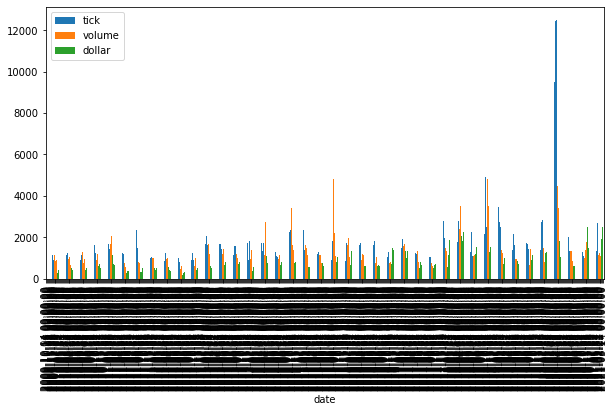

In [ ]:
count_df = pd.concat([weekly_tick_count, weekly_vol_count, weekly_dollar_count], axis=1)
count_df.columns = ['tick', 'volume', 'dollar']
count_df.loc[:, ['tick', 'volume', 'dollar']].plot(kind = 'bar', figsize=[10, 5])
ax.spines['bottom'].set_visible(False)

(c) Compute the serial correlation of returns for the three bar types. What bar method has the lowest serial correlation?

In [ ]:
pd.DataFrame(data={'autocorr':[count_df['dollar'].autocorr(),
                               count_df['volume'].autocorr(),
                               count_df['tick'].autocorr()]},
                               index=['tick', 'vol', 'dollar'])
# 전후관계의 상관관계가 높음 -> 로그 수익률

,autocorr
tick,0.753118
vol,0.703512
dollar,0.730188


In [ ]:
# log returns
tick_returns = np.log(tick_df.price).diff().dropna()
vol_returns = np.log(vol_df.price).diff().dropna()
dollar_returns = np.log(dollar_df.price).diff().dropna()

In [ ]:
pd.DataFrame(data={'returns_autocorr':[tick_returns.autocorr(),
                                       vol_returns.autocorr(),
                                       dollar_returns.autocorr()]},
                               index=['tick', 'vol', 'dollar'])

,returns_autocorr
tick,-0.014101
vol,-0.040060
dollar,0.058046


(d) Partition the bar series into monthly subsets. Compute the variance of returns for every subset of every bar type. Compute the variance of those variances. What method exhibits the smallest variance of variances?

In [ ]:
monthly_tick_returns_var = tick_returns.resample('M').var()
monthly_vol_returns_var = vol_returns.resample('M').var()
monthly_dollar_retuns_var = dollar_returns.resample('M').var()

In [ ]:
pd.DataFrame(data = {'variance':[monthly_tick_returns_var.var(), monthly_vol_returns_var.var(), monthly_dollar_retuns_var.var()]},
             index = ['tick', 'volume', 'dollar'])

,variance
tick,1.593371e-11
volume,2.205118e-11
dollar,5.267423e-11



(e) Apply the Jarque-Bera normality test on returns from the three bar types. What method achieves the lowest test statistic?

In [ ]:
from scipy.stats import jarque_bera

In [ ]:
jb_value_tick, _ = jarque_bera(tick_returns)
jb_value_vol, _ = jarque_bera(vol_returns)
jb_value_dollar, _ = jarque_bera(dollar_returns)

In [ ]:
pd.DataFrame(data={'jarque_bera_results' : [jb_value_tick, jb_value_vol, jb_value_dollar]},
                          index=['tick', 'vol', 'dollar'])

,jarque_bera_results
tick,4.225907e+13
vol,2.648322e+13
dollar,5.779185e+12


In [ ]:
tick_standard = (tick_returns - tick_returns.mean()) / tick_returns.std()
volume_standard = (vol_returns - vol_returns.mean()) / vol_returns.std()
dollar_standard = (dollar_returns - dollar_returns.mean()) / dollar_returns.std()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.25 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.25 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.25 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


(-5.0, 5.0)

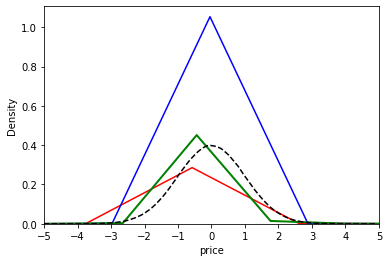

In [ ]:
import seaborn as sns 

fig, ax = plt.subplots()

sns.kdeplot(tick_standard, 
            ax=ax,
            label="Tick", 
            bw=0.25,
            color='red')
sns.kdeplot(volume_standard,
            ax=ax,
            label="Volume",
            bw=0.25,
            color='blue')
sns.kdeplot(dollar_standard,
            ax=ax,
            label="Dollar",
            bw=0.25,
            linewidth=2, 
            color='green') #달러 바가 확실히 정규분포에 가까움 
sns.kdeplot(np.random.normal(size=len(tick_standard)),
            ax=ax,
            label="Normal",
            color='black',
            linestyle="--")
ax.set_xticks(range(-5, 6))
ax.set_xlim(-5, 5)

##`2.4`
Form E-mini S&P 500 futures `dollar bars`:

(a) Compute Bollinger bands of width 5% around a rolling moving average. Count how many times prices cross the bands out (from within the bands to outside the bands).

In [ ]:
N = 20
K = 1.96
ma = dollar_df.price.rolling(N).mean()
sigma = dollar_df.price.rolling(N).std()
upper_band = ma + K*sigma
lower_band = ma - K*sigma

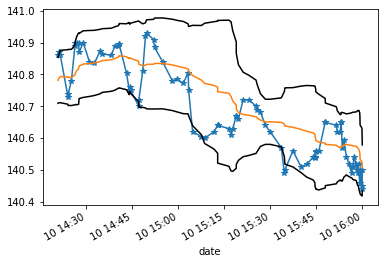

In [ ]:
fig, ax = plt.subplots(1)
dollar_df.iloc[-100:].price.plot(ax=ax, marker='*')
ma.iloc[-100:].plot(ax=ax)
upper_band.iloc[-100:].plot(ax=ax, color='k')
lower_band.iloc[-100:].plot(ax=ax, color='k')

In [ ]:
N = 20
ma = dollar_df.price.rolling(N).mean()
price_pct = 0.001
upper_band = ma + ma*price_pct
lower_band = ma - ma*price_pct
bb_dataframe = pd.concat([dollar_df.price, ma, upper_band, lower_band], axis=1).dropna()
bb_dataframe.columns=['price','ma','upper_band','lower_band']

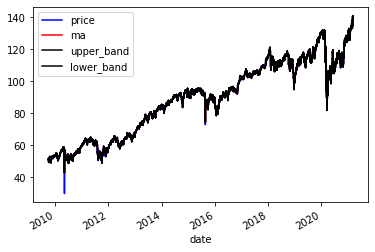

In [ ]:
fig, ax = plt.subplots(1)
bb_dataframe.plot(ax=ax, color=['b','r', 'k', 'k'])

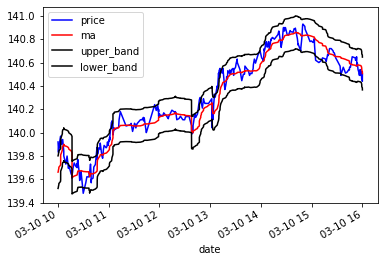

In [ ]:
s_date='2021-03-10 10'
e_date='2021-03-10 16'

fig, ax = plt.subplots(1)
bb_dataframe.loc[s_date:e_date].plot(ax=ax, color=['b','r', 'k', 'k'])

In [ ]:
count_up = dollar_df[dollar_df.price > upper_band]
count_up.shape

(97768, 5)

In [ ]:
count_dn = dollar_df[dollar_df.price < lower_band]
count_dn.shape

(94718, 5)

(b) Now sample those bars using a CUSUM filter, where {$y_t$} are returns and h = 0.05. How many samples do you get?






In [ ]:
def cumsum_events(df: pd.Series, limit: float):
    idx, _up, _dn = [], 0, 0
    diff = df.diff()
    for i in range(1, len(diff)):
        _up, _dn = max(0, _up + diff.iloc[i]), min(0, _dn + diff.iloc[i])
        if _up > limit:
            _up = 0; idx.append(diff.index[i])
        elif _dn < - limit:
            _dn = 0; idx.append(diff.index[i])
        
    return pd.DatetimeIndex(idx)

In [ ]:
def cumsum_events1(df: pd.Series, limit: float):
    idx, _up, _dn = [], 0, 0
    diff = df.pct_change()
    for i in range(1, len(diff)):
        _up, _dn = max(0, _up + diff.iloc[i]), min(0, _dn + diff.iloc[i])
        if _up > limit:
            _up = 0; idx.append(diff.index[i])
        elif _dn < - limit:
            _dn = 0; idx.append(diff.index[i])
        
    return pd.DatetimeIndex(idx)

In [ ]:
event = cumsum_events(dollar_df.price, 0.05)

In [ ]:
event_pct = cumsum_events1(dollar_df.price, 0.05)

In [ ]:
print(len(event))
print(len(event_pct))

150836
257


(c) Compute the rolling standard deviation of the two-sampled series. Which one is least heteroscedastic? What is the reason for these results?

In [ ]:
import statsmodels.stats.diagnostic as sm
import statsmodels.api as smi

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
without_filter = pd.concat([count_up, count_dn])
with_filter = dollar_df.loc[dollar_df.index.intersection(event)]
with_fliter_pct = dollar_df.loc[dollar_df.index.intersection(event_pct)]

In [ ]:
def white_test(data: pd.DataFrame, window: int = 21):
    data['std1'] = data['price'].rolling(21).std()
    data.dropna(inplace= True)
    X = smi.tools.tools.add_constant(data['price'])
    results = smi.regression.linear_model.OLS(data['std1'], X).fit()
    resid = results.resid
    exog = results.model.exog
    print("White-Test p-Value: {0}".format(sm.het_white(resid, exog)[1]))
    if sm.het_white(resid, exog)[1] > 0.05:
        print("White test outcome at 5% signficance: homoscedastic")
    else:
        print("White test outcome at 5% signficance: heteroscedastic")

In [ ]:
white_test(without_filter)

White-Test p-Value: 1.586087154489769e-23
White test outcome at 5% signficance: heteroscedastic


In [ ]:
white_test(with_filter)

White-Test p-Value: 1.731136687003757e-35
White test outcome at 5% signficance: heteroscedastic


In [ ]:
white_test(with_fliter_pct) #수익율로 계산한 것이 등분산성을 띔 

White-Test p-Value: 0.21755677049027805
White test outcome at 5% signficance: homoscedastic
